In [7]:
# If you'd like to use GPU, please uncomment the following lines
# %set_env CUDA_VISIBLE_DEVICES=0
# %load_ext cudf.pandas
import pandas as pd
from unibench.benchmarks_zoo.registry import list_benchmarks
from unibench.models_zoo.registry import list_models
from unibench.output import OutputHandler
import seaborn as sns
import matplotlib.pyplot as plt
from unibench.common_utils.utils import get_model_mappings, get_benchmark_mappings

models = [
    "openclip_vitB32_400m",
    "openclip_vitL14_400m",
    "eva01_vitG14_400m",
    "openclip_vitB32_2b",
    "openclip_vitB32_datacomp_s",
    "openclip_vitB32_datacomp_m",
    "openclip_vitB32_datacomp_xl",
    "openclip_vitB32_metaclip_fullcc",
    "openclip_vitB32_metaclip_400m",
]
datasets = ["dmlab", "kitti_distance", "mnist"]
outputhandler = OutputHandler(output_dir="/fsx-robust/haideraltahan/outputs")

params = ["dataset_size", "model_size"]
models_params = [
    [
        "openclip_vitB32_2b",
        "openclip_vitB32_datacomp_s",
        "openclip_vitB32_datacomp_m",
        "openclip_vitB32_datacomp_xl",
        "openclip_vitB32_metaclip_fullcc",
        "openclip_vitB32_metaclip_400m",
    ],
    [
        "openclip_vitB32_400m",
        "openclip_vitL14_400m",
        "eva01_vitG14_400m",
    ],
]

xlabels = ["Training Dataset Size (Million)", "Model Size (Million)"]

In [8]:
outputhandler.load_all_csv(
    model_name=models,
    benchmark_name=datasets,
)
results = outputhandler.query(**{"benchmark_name": datasets, "model_name": models})

In [9]:
for param in params:
    model_mappings = get_model_mappings(param)
    results[param] = results["model_name"].map(model_mappings)

In [10]:
dataset_mappings = get_benchmark_mappings("capability")
results["benchmark_type"] = results["benchmark_name"].map(dataset_mappings)

In [11]:
df_mean = (
    results.groupby(["model_name", "benchmark_name", "benchmark_type"] + params)
    .correctness.mean()
    .reset_index()
    .groupby(["model_name", "benchmark_name", "benchmark_type"] + params)
    .correctness.mean()
    .reset_index()
    .groupby(["benchmark_type", "model_name"] + params)
    .correctness.median()
)
df_sem = (
    results.groupby(["model_name", "benchmark_name", "benchmark_type"] + params)
    .correctness.mean()
    .reset_index()
    .groupby(["model_name", "benchmark_name", "benchmark_type"] + params)
    .correctness.mean()
    .reset_index()
    .groupby(["benchmark_type", "model_name"] + params)
    .correctness.sem()
)

dataset_types = list(df_mean.reset_index().benchmark_type.unique())

2it [00:00, 35.00it/s]


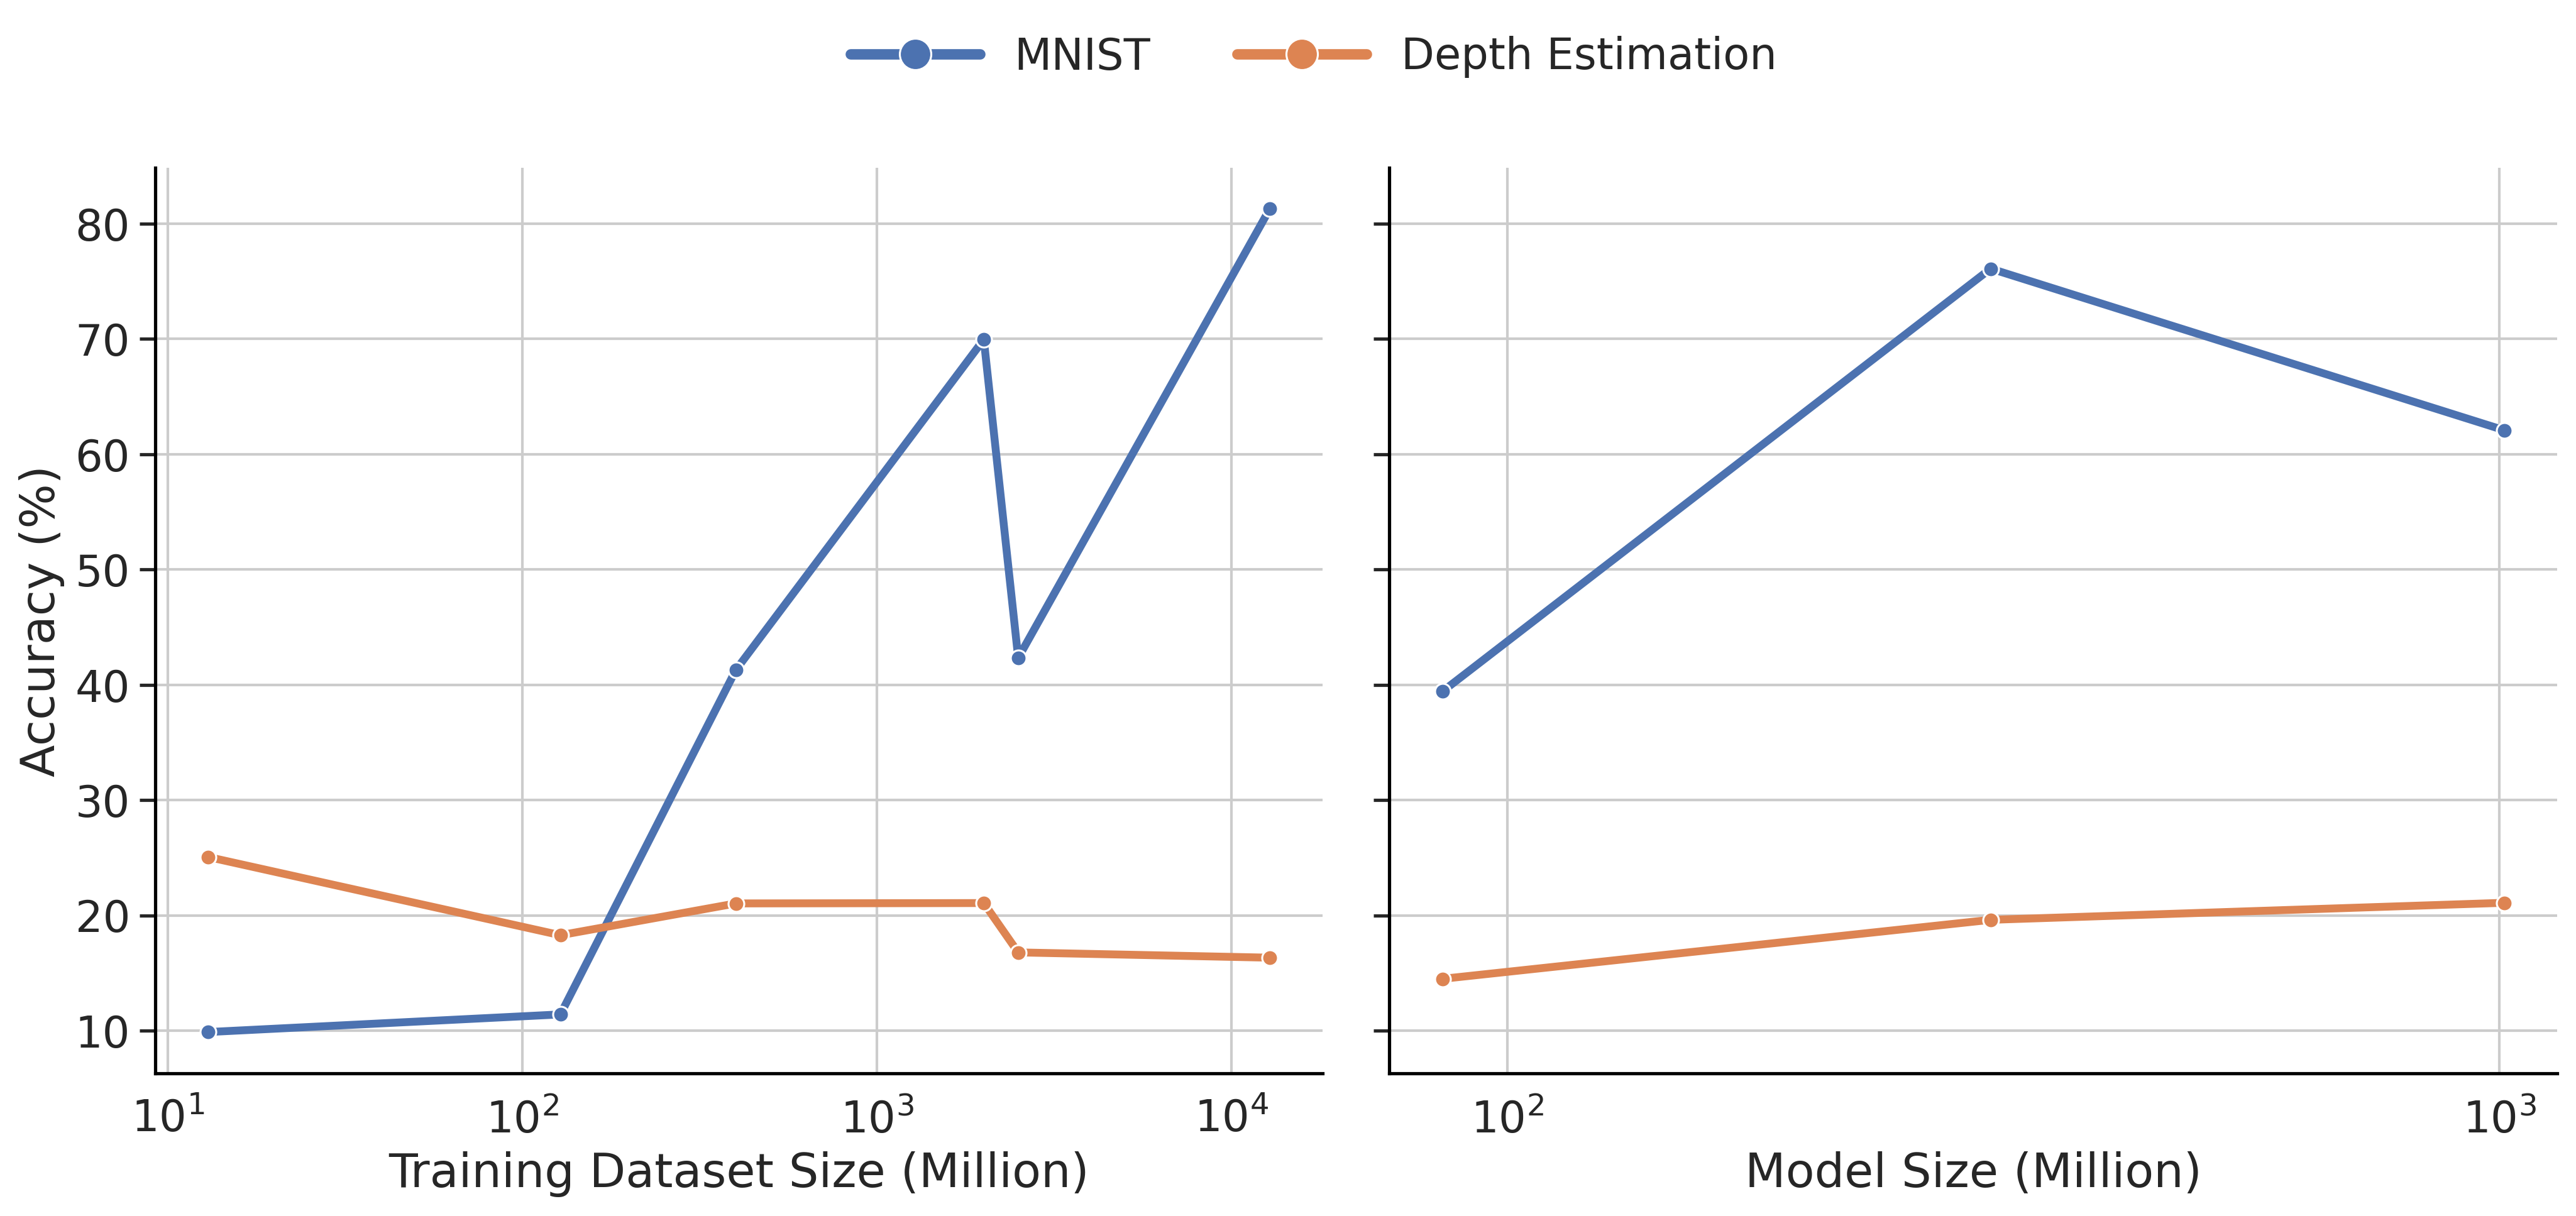

In [15]:
from tqdm import tqdm

sns.set(font_scale=1.5)
sns.set_style(
    "whitegrid",
    rc={"ytick.left": True, "axes.grid": True},
)
fig, axs = plt.subplots(
    1,
    len(params),
    sharey=True,
    figsize=(14, 6),
    dpi=300,
)
for i, (param, ax) in tqdm(enumerate(zip(params, list(axs.flat)))):

    df_m = (
        df_mean.reset_index()[df_mean.reset_index().model_name.isin(models_params[i])]
        .groupby(["benchmark_type"] + [param])
        .correctness.median()
        .reset_index()
    )
    df_m.correctness = df_m.correctness * 100
    df_s = (
        df_sem.reset_index()[df_sem.reset_index().model_name.isin(models_params[i])]
        .groupby(["benchmark_type"] + [param])
        .correctness.sem()
        .reset_index()
    )
    df_s.correctness = df_s.correctness * 100

    ax = sns.lineplot(
        data=df_m.reset_index(),
        x=param,
        y="correctness",
        hue="benchmark_type",
        ax=ax,
        legend=i == 0,
        marker="o",
        linewidth=3,
    )

    if i == 0:
        h, l = ax.get_legend_handles_labels()
        ax.legend_.remove()
    ax.set(xscale="log")

    ax.set_xlabel(xlabels[i])
    ax.set_ylabel("Accuracy (%)")
    sns.despine(ax=ax)
    for _, s in ax.spines.items():
        s.set_color("black")

leg = fig.legend(
    h,
    ["MNIST" if label == "character recognition" else label.title() for label in l],
    loc="lower right",
    bbox_to_anchor=(0.7, 1),
    ncol=4,
    frameon=False,
    markerscale=2,
    handlelength=3,
)
plt.setp(leg.get_lines(), linewidth=4)

plt.tight_layout()
plt.savefig("results_mnist_depth.pdf", dpi=300, bbox_inches="tight")